## The Problem: Large Movie Dataset Review
### Classify movie reviews from IMDB into positive or negative sentiment.
### Download the dataset [here](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

In [1]:
!pip install gensim tensorflow


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# imports

from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Input, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import utils

2025-02-16 03:51:15.909891: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-16 03:51:15.914077: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-16 03:51:15.928045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739677875.953012    2127 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739677875.959960    2127 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 03:51:15.983465: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Exploring the data

In [3]:
# Importing & preprocessing the dataset

train_ds = text_dataset_from_directory('../../Distributional_Semantics_Code_Files/aclImdb/train')
test_ds = text_dataset_from_directory('../../Distributional_Semantics_Code_Files/aclImdb/test')

dfTrain = pd.DataFrame(train_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
dfTest = pd.DataFrame(test_ds.unbatch().as_numpy_iterator(), columns=['text', 'label'])
_, xts = train_test_split(dfTest, stratify=dfTest['label'], test_size=0.25)

dfTrain['text'] = dfTrain['text'].map(lambda x: x.decode())
xts['text'] = xts['text'].map(lambda x: x.decode())

Found 75000 files belonging to 3 classes.


2025-02-16 03:51:20.982113: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 25000 files belonging to 2 classes.


2025-02-16 03:51:44.701594: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-16 03:51:53.132137: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
pd.options.display.max_colwidth = 200
dfTrain.sample(n=5)

,text,label
59342,"I flagged this ""review"" as having a spoiler however I don't think anything I say could possibly spoil this movie. My only reason for writing is to report a ""goof"" and can't seem to find the proper...",2
1477,"The budget for Mars was about $1 million US. That wasn't much money, and almost all of it went to the film's paltry CGI effects, and one explosion scene. <br /><br />The film was shot by a first t...",2
27297,*may contain a spoiler of sorts?* The mere mention of Crispin Glover is enough to send some geek's panties in a bunch. His landmark appearance in Back to the Future as George McFly has sealed him ...,0
46680,I loved Aladdin. I bought Return of Jafar the day it was released on video. I wrapped it and put it under the tree for my 3 year old daughter. I counted the days til we could open it and watch the...,2
57498,"I'm guessing that everybody knows the story of this movie by now, but for those who might not have had the opportunity to see this great movie, it's quite a simple formula. The Miami Dolphins masc...",2


In [5]:
print(dfTrain.loc[0, 'text'])

This movie of 370 minutes was aired by the Italian public television during the early seventies. It tells you the myth attributed to Homer of the Journey home of Odysseus after the Troy war. It is an epic story about the ancient Minoan and Mycenaean civilizations, told at list 500 years after those events toke place, around 1100 BC.<br /><br />This is a 1969 movie, so if you buy the DVD version you would find that the sound is just mono and there is no other language than Italian, even the close caption is in Italian. Pity. Many people would enjoy this masterpiece if it had at list the English subtitles. But if this is not a problem for you, than I would strongly recommend to watch this movie.


## Tokenize the text

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfTrain['text'].tolist())
train_sequences = tokenizer.texts_to_sequences(dfTrain['text'].tolist())
test_sequences = tokenizer.texts_to_sequences(xts['text'].tolist())


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 153845 unique tokens.


In [7]:
print(train_sequences[0])

[11, 17, 4, 58547, 230, 13, 3281, 31, 1, 1059, 1038, 732, 294, 1, 407, 3992, 9, 706, 22, 1, 4929, 10766, 5, 7796, 4, 1, 1374, 342, 4, 31654, 99, 1, 6199, 306, 9, 6, 32, 1661, 63, 41, 1, 2302, 87409, 2, 87410, 20823, 586, 30, 1006, 7298, 151, 99, 144, 699, 58548, 266, 185, 40751, 17445, 7, 7, 11, 6, 3, 5302, 17, 36, 45, 22, 809, 1, 283, 332, 22, 58, 167, 12, 1, 497, 6, 40, 14581, 2, 47, 6, 54, 84, 1092, 71, 1059, 56, 1, 499, 20397, 6, 8, 1059, 2348, 108, 81, 58, 367, 11, 985, 45, 9, 67, 30, 1006, 1, 661, 2303, 18, 45, 11, 6, 21, 3, 430, 16, 22, 71, 10, 58, 2349, 390, 5, 105, 11, 17]


In [8]:
print([tokenizer.index_word[k] for k in train_sequences[0]])

['this', 'movie', 'of', '370', 'minutes', 'was', 'aired', 'by', 'the', 'italian', 'public', 'television', 'during', 'the', 'early', 'seventies', 'it', 'tells', 'you', 'the', 'myth', 'attributed', 'to', 'homer', 'of', 'the', 'journey', 'home', 'of', 'odysseus', 'after', 'the', 'troy', 'war', 'it', 'is', 'an', 'epic', 'story', 'about', 'the', 'ancient', 'minoan', 'and', 'mycenaean', 'civilizations', 'told', 'at', 'list', '500', 'years', 'after', 'those', 'events', 'toke', 'place', 'around', '1100', 'bc', 'br', 'br', 'this', 'is', 'a', '1969', 'movie', 'so', 'if', 'you', 'buy', 'the', 'dvd', 'version', 'you', 'would', 'find', 'that', 'the', 'sound', 'is', 'just', 'mono', 'and', 'there', 'is', 'no', 'other', 'language', 'than', 'italian', 'even', 'the', 'close', 'caption', 'is', 'in', 'italian', 'pity', 'many', 'people', 'would', 'enjoy', 'this', 'masterpiece', 'if', 'it', 'had', 'at', 'list', 'the', 'english', 'subtitles', 'but', 'if', 'this', 'is', 'not', 'a', 'problem', 'for', 'you', 't

In [9]:
MAX_SEQUENCE_LENGTH = max([max(map(len, train_sequences)), max(map(len, test_sequences))])

In [10]:
MAX_SEQUENCE_LENGTH

2493

In [11]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [12]:
print([tokenizer.index_word.get(k, '<PAD>') for k in train_data[0]])

['<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', 

# Train a classifier with Word Embeddings

In [13]:
countries_wiki = KeyedVectors.load('wiki-countries.w2v')

In [14]:
embedding_layer = utils.make_embedding_layer(countries_wiki, tokenizer, MAX_SEQUENCE_LENGTH)
countries_wiki_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
countries_wiki_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-02-16 03:52:27.034267: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78769152 exceeds 10% of free system memory.
2025-02-16 03:52:27.164757: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78769152 exceeds 10% of free system memory.
2025-02-16 03:52:27.195460: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78769152 exceeds 10% of free system memory.
2025-02-16 03:52:27.538262: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78769152 exceeds 10% of free system memory.


In [15]:
countries_wiki_history = countries_wiki_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=64, epochs=30
)

Epoch 1/30


2025-02-16 03:52:28.250962: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 747900000 exceeds 10% of free system memory.


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.1639 - loss: -3994.3389 - val_accuracy: 0.5000 - val_loss: 63692.4883
Epoch 2/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.1663 - loss: -130006.0703 - val_accuracy: 0.5000 - val_loss: 435796.2500
Epoch 3/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.1652 - loss: -606502.6250 - val_accuracy: 0.5000 - val_loss: 1254196.8750
Epoch 4/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.1661 - loss: -1556013.6250 - val_accuracy: 0.5000 - val_loss: 2584529.0000
Epoch 5/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.1671 - loss: -3030602.0000 - val_accuracy: 0.5000 - val_loss: 4492266.0000
Epoch 6/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.1665 - loss: -5113993.0000 - val_accuracy: 0.5000 - val_loss: 7031972.0000
Epoch 7/30
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.1654 - loss: -7904877.5000 - val_accuracy: 0.5000 - val_loss: 10264218.0000
Epo

# Train with a different set of word embeddings

## GloVe: Global Vectors for Word Representation
### Download [here](http://nlp.stanford.edu/data/glove.6B.zip)

In [16]:
glove_wiki = KeyedVectors.load_word2vec_format('../../glove.6B.100d.txt', binary=False, no_header=True)

In [17]:
embedding_layer = utils.make_embedding_layer(glove_wiki, tokenizer, MAX_SEQUENCE_LENGTH)

glove_model = Sequential([
    Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'),
    embedding_layer,
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
glove_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])



In [18]:
glove_history = glove_model.fit(
    train_data, dfTrain['label'].values,
    validation_data=(test_data, xts['label'].values),
    batch_size=32, epochs=30
)


Epoch 1/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.1677 - loss: -8122.0439 - val_accuracy: 0.5000 - val_loss: 112689.8984
Epoch 2/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.1659 - loss: -218602.6094 - val_accuracy: 0.5000 - val_loss: 656070.1875
Epoch 3/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1674 - loss: -914872.1875 - val_accuracy: 0.5000 - val_loss: 1783450.6250
Epoch 4/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1690 - loss: -2240653.7500 - val_accuracy: 0.5000 - val_loss: 3620209.5000
Epoch 5/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1667 - loss: -4324481.0000 - val_accuracy: 0.5000 - val_loss: 6296530.5000
Epoch 6/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1657 - loss: -7250474.5000 - val_accuracy: 0.5000 - val_loss: 9953945.0000
Epoch 7/30
2344/2344 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.1668 - loss: -11299536.0000 - val_accuracy: 0.5000 - val_loss: 14706298.00

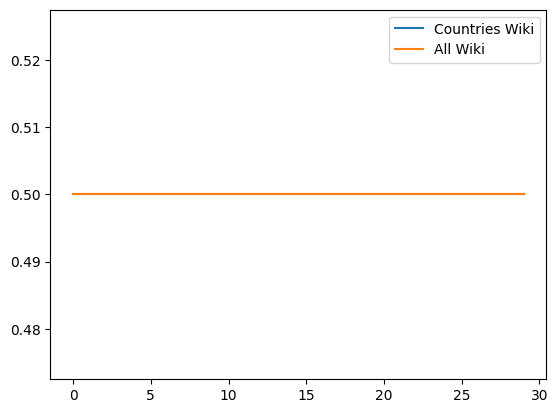

In [19]:
plt.plot(countries_wiki_history.history['val_accuracy'], label='Countries Wiki')
plt.plot(glove_history.history['val_accuracy'], label='All Wiki')
plt.legend()


In [20]:
import datetime, pytz; 
print("Current Time in IST:", datetime.datetime.now(pytz.utc).astimezone(pytz.timezone('Asia/Kolkata')).strftime('%Y-%m-%d %H:%M:%S'))






Current Time in IST: 2025-02-16 09:37:41
